In [45]:
%matplotlib inline
%load_ext autoreload

import sys
import csv
import multiprocessing

import ujson
import keras
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, GlobalMaxPooling1D, MaxPool1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
import tensorflow as tf
import gensim
from gensim.models.fasttext import FastText
from gensim.parsing.preprocessing import preprocess_string
import pandas as pd
from tqdm import tqdm 
import seaborn as sns
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
csv.field_size_limit(500 * 1024 * 1024)

131072

In [3]:
path_data = 'data/fake_news_corpus/'
path_news_csv = path_data + 'news_cleaned_2018_02_13.csv'
path_fasttext = path_data + 'news_cleaned_2018_02_13.fasttext.bin'
path_news_preprocessed = path_data + 'news_cleaned_2018_02_13.preprocessed.jsonl'
path_news_shuffled = path_data + 'news_cleaned_2018_02_13.preprocessed.shuffled.jsonl'
path_news_train = path_data + 'news_cleaned_2018_02_13.preprocessed.shuffled.train.jsonl'
path_news_test = path_data + 'news_cleaned_2018_02_13.preprocessed.shuffled.test.jsonl'
path_news_val = path_data + 'news_cleaned_2018_02_13.preprocessed.shuffled.val.jsonl'

path_news_embedded = path_data + 'news_cleaned_2018_02_13.embedded.jsonl'

# Load FastText

In [5]:
fasttext = FastText.load_fasttext_format(path_fasttext)

# Load news_cleaned

In [ ]:
for df_news_chunk in pd.read_csv(path_news_csv, chunksize=1000):
    break

# Prepare the input data 

## Make sure the file is correct

In [ ]:
with tqdm() as progress:
    for df_news_chunk in pd.read_csv(path_news_csv, encoding='utf-8', engine='python', chunksize=1000):
        progress.update()

## News generator

In [7]:
def news_generator():
    with tqdm() as progress:
        for df_news_chunk in pd.read_csv(path_news_csv, encoding='utf-8', engine='python', chunksize=10 * 1000):
            news_filter = df_news_chunk.type.isin(set(['fake', 'conspiracy', 'unreliable', 'reliable']))
            df_news_chunk_filtered = df_news_chunk[news_filter]
            for row in df_news_chunk_filtered.itertuples():
                label = 1 if row.type == 'reliable' else 0

                progress.update()
                yield int(row.id), '%s %s' % (row.title, row.content), label

## Show text length distribution

In [12]:
lens = []
for i, (_id, con, label) in enumerate(news_generator()):
    if i > 10 * 1000:
        break

    lens.append(len(con))

10002it [00:01, 5714.80it/s]


In [13]:
len(lens), sum(lens) / len(lens), max(lens), min(lens)

(10001, 4767.068493150685, 100091, 59)

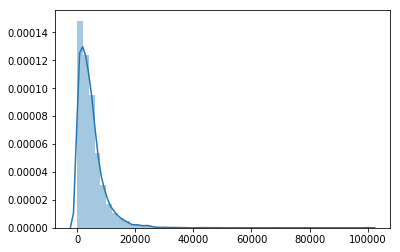

In [14]:
sns.distplot(lens)

## Preprocess  

In [15]:
def _preprocess_string(news):
    _id, con, label = news
    return _id, preprocess_string(con), label

def news_preprocessed_generator():
    missing_words = {}
    
    with multiprocessing.Pool(multiprocessing.cpu_count(), maxtasksperchild=1) as pool:
        for _id, con, label in pool.imap(_preprocess_string, news_generator(), chunksize=1000):
            yield _id, con, label, missing_words

In [16]:
all_missing_words = {}
with open(path_news_preprocessed, 'w') as out_news_embedded:
    for _id, con, label, missing_words in news_preprocessed_generator():
        out_news_embedded.write(ujson.dumps({
            'id': _id, 'content': con, 'label': int(label)
        }) + '\n')
        all_missing_words.update(missing_words)

3937987it [1:41:54, 644.00it/s] 


In [17]:
!shuf data/fake_news_corpus/news_cleaned_2018_02_13.preprocessed.jsonl > \
      data/fake_news_corpus/news_cleaned_2018_02_13.preprocessed.shuffled.jsonl

## Split into train, validation, and test

In [18]:
count_lines = 0
with open(path_news_shuffled, 'r') as in_news:
    for line in in_news:
        count_lines += 1

In [20]:
count_lines, int(count_lines * .8), int(count_lines * .1), \
    count_lines - (int(count_lines * 0.8) + int(count_lines * 0.1))

(3937987, 3150389, 393798, 393800)

In [21]:
train_size = int(count_lines * .8)
test_size = int(count_lines * .8)
val_size = count_lines - (int(count_lines * 0.8) + int(count_lines * 0.1))

In [22]:
with open(path_news_shuffled, 'r') as in_news:
    with open(path_news_train, 'w') as out_train:
        with open(path_news_test, 'w') as out_test:
            with open(path_news_val, 'w') as out_val:
                for i, line in tqdm(enumerate(in_news)):
                    if i < count_lines * .8:
                        out_train.write(line)
                    elif i < count_lines * .9:
                        out_test.write(line)
                    else:
                        out_val.write(line)

3937987it [00:22, 177646.44it/s]


## Generators

In [50]:
max_words = 200

In [56]:
def _news_generator_process_line(line):
    article = ujson.loads(line)

    embedding = np.zeros((max_words, 100))
    for i, word in enumerate(article['content'][:max_words]):
        if word in fasttext:
            embedding[i] = fasttext[word]
            
    return embedding, article['label']

def news_generator(path, batch):
    while True:
        with open(path_news_shuffled, 'r') as in_news:
            with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
                batch_i = 0
                batch_embedding = np.zeros((batch, max_words, 100))
                batch_label = np.zeros((batch, 1))
                for embedding, label in pool.imap(_news_generator_process_line, in_news, chunksize=250):
                    if (batch_i + 1) == batch:
                        yield batch_embedding, batch_label
                        batch_embedding = np.zeros((batch, max_words, 100))
                        batch_label = np.zeros((batch, 1))
                        batch_i = 0
                    else:
                        batch_embedding[batch_i] = embedding
                        batch_label[batch_i, 0] = label
                        batch_i += 1

# Simple CNN model for classyfing fake vs reliable

In [57]:
input_shape = max_words, 100

filters = 250
kernel_size = 3
hidden_dims = 250

batch_size = 16
epochs = 1

In [ ]:
def cnn_simple_model(input_shape, filters=250, kernel_size=3, hidden_dims=250):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, input_shape=(input_shape[0], input_shape[1]), padding='valid', 
               activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
#     model.add(Conv1D(filters, kernel_size, activation='relu'))
#     model.add(GlobalMaxPooling1D())
    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
with tf.device('/gpu:0'):
    cnn_model = cnn_simple_model(input_shape, filters, kernel_size, hidden_dims)
    cnn_model.fit_generator(news_generator(path_news_train, batch_size), steps_per_epoch=train_size // batch_size, 
                            epochs=epochs, verbose=1, validation_data=news_generator(path_news_val, batch_size), 
                            validation_steps=val_size // batch_size)

In [60]:
def cnn_deep_model(input_shape, filters=512, kernel_size=3, drop = 0.5, filter_sizes=(3,4,5)):
    # https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py
    
    inputs = Input(shape=input_shape)

    maxpools = []
    for filter_size in filter_sizes:
        conv = Conv1D(filters, kernel_size=filter_size, padding='valid', 
                      kernel_initializer='normal', activation='relu')(inputs)
        maxpool = MaxPool1D(pool_size=max_words - filter_size + 1, strides=1, 
                            padding='valid')(conv)
        maxpools.append(maxpool)
        
    concatenated_tensor = Concatenate(axis=1)(maxpools)
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(1, activation='softmax')(dropout)

    # this creates a model that includes
    model = Model(inputs=inputs, outputs=output)

    checkpoint = ModelCheckpoint(path_data + 'weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, 
                                 save_best_only=True, mode='auto')
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [61]:
with tf.device('/gpu:0'):
    cnn_model = cnn_deep_model(input_shape)
    cnn_model.fit_generator(news_generator(path_news_train, batch_size), steps_per_epoch=train_size // batch_size, 
                            epochs=epochs, verbose=1, validation_data=news_generator(path_news_val, batch_size), 
                            validation_steps=val_size // batch_size)

Epoch 1/1


Exception in thread Thread-24:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/utils/data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-56-87efacac9e1b>", line 14, in news_generator
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
  File "/usr/lib/python3.5/multiprocessing/context.py", line 118, in Pool
    context=self.get_context())
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 168, in __init__
    self._repopulate_pool()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 233, in _repopulate_pool
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/

StopIteration: 

In [ ]:
Input